## Import Libraries and Dataset Loading

In [1]:
import pandas as pd
import ast
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
# Load your dataset
df = pd.read_csv('movies_youtube_sentiments.csv')

# Parse sentiment_scores column
df['sentiment_scores'] = df['sentiment_scores'].apply(ast.literal_eval)
df['positive'] = df['sentiment_scores'].apply(lambda x: x.get('positive', 0))
df['neutral'] = df['sentiment_scores'].apply(lambda x: x.get('neutral', 0))
df['negative'] = df['sentiment_scores'].apply(lambda x: x.get('negative', 0))

## Exploratory Data Analysis

In [7]:
print(df.isnull().sum())

name                  0
trailer_link          0
video_id              0
sentiment_scores      0
favorability          0
rating                1
genre                 0
year                  0
released              0
votes                 0
director              0
writer                1
star                  0
country               0
budget              204
gross                 0
company               0
runtime               1
positive              0
neutral               0
negative              0
dtype: int64


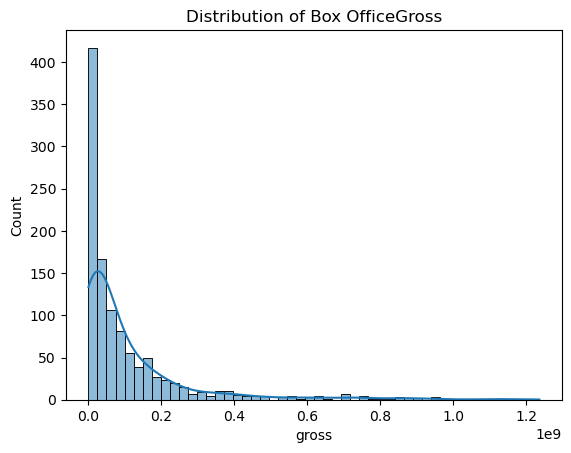

In [9]:
# Distribution of gross
sns.histplot(df['gross'], bins=50, kde=True)
plt.title("Distribution of Box OfficeGross")
plt.show()

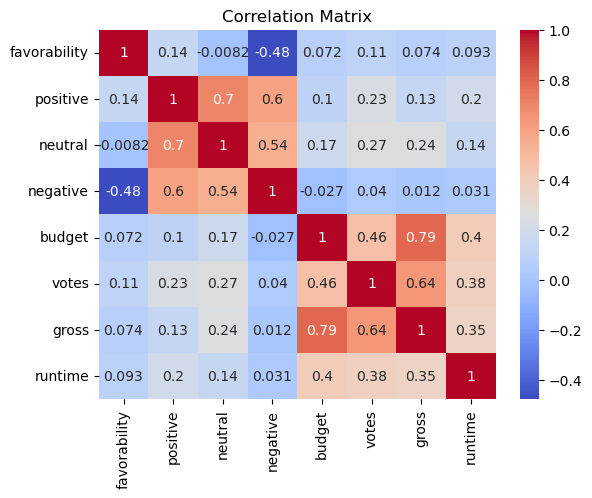

In [11]:
# Correlation heatmap
numerical_cols = ['favorability', 'positive', 'neutral', 'negative', 'budget', 'votes', 'gross', 'runtime']
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

## Sentiment Analysis by Genre

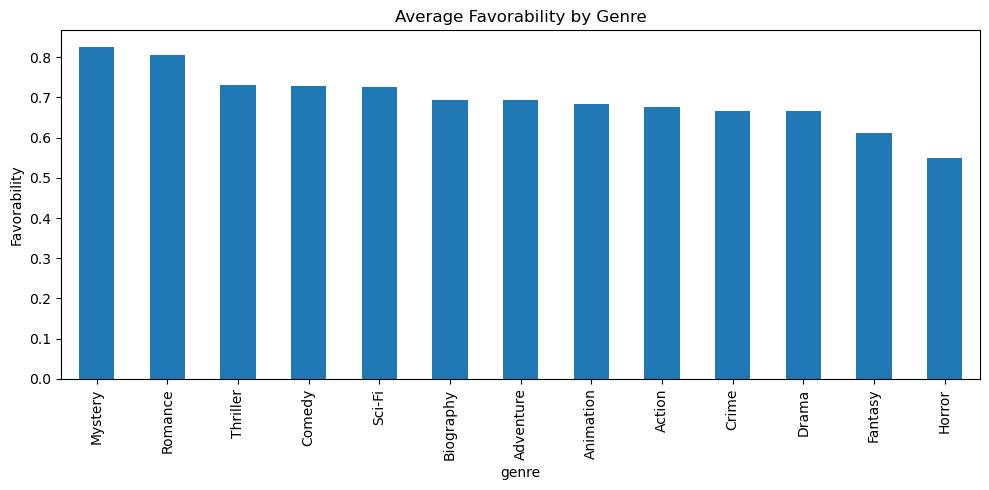

In [12]:
genre_sentiment = df.groupby('genre')[['positive', 'neutral', 'negative', 'favorability']].mean().sort_values(by='favorability', ascending=False)

# Plot average favorability by genre
genre_sentiment['favorability'].plot(kind='bar', figsize=(10, 5), title='Average Favorability by Genre')
plt.ylabel('Favorability')
plt.tight_layout()
plt.show()

## Data Cleaning and Feature Engineering

In [15]:
# Drop rows with missing values in key fields
df_clean = df.dropna(subset=['budget', 'gross', 'runtime'])

# Encode categorical variables (e.g., genre)
df_model = pd.get_dummies(df_clean, columns=['genre', 'rating'], drop_first=True)

# Features and Target
X = df_model[['favorability', 'positive', 'neutral', 'negative', 'budget', 'votes', 'runtime'] + 
             [col for col in df_model.columns if col.startswith('genre_') or col.startswith('rating_')]]
y = df_model['gross']

## Regression Modeling

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print("R^2 Score:", r2_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))

R^2 Score: 0.6924700522429612
RMSE: 113195054.77151147


In [22]:
import numpy as np

# Apply log transformation to the target
df_model['log_gross'] = np.log1p(df_model['gross'])

# New target
y_log = df_model['log_gross']

# Split again
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Linear Regression on log target
log_model = LinearRegression()
log_model.fit(X_train_log, y_train_log)
y_pred_log = log_model.predict(X_test_log)

# Evaluate
from sklearn.metrics import mean_squared_error, r2_score
print("R² (Log Target):", r2_score(y_test_log, y_pred_log))
print("RMSE (Log Target):", mean_squared_error(y_test_log, y_pred_log, squared=False))


R² (Log Target): 0.49693343144757407
RMSE (Log Target): 1.23188501441294


## Model Summary

In [25]:
# Combine coefficients and feature names
model_summary = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_})
model_summary = model_summary.sort_values(by='Coefficient', ascending=False)
print(model_summary)

             Feature   Coefficient
15     genre_Mystery  3.429739e+08
14      genre_Horror  3.795016e+07
19      rating_NC-17  2.974328e+07
0       favorability  2.453869e+07
18    genre_Thriller  2.114592e+07
10      genre_Comedy  1.546108e+07
20  rating_Not Rated  1.319617e+07
25    rating_Unrated  1.119371e+07
22      rating_PG-13  9.377380e+06
13     genre_Fantasy  8.452086e+06
21         rating_PG  5.498452e+06
11       genre_Crime  3.163527e+06
2            neutral  4.537981e+05
3           negative  1.099670e+05
5              votes  2.997441e+02
4             budget  2.405321e+00
6            runtime -4.134021e+04
1           positive -3.103910e+05
7    genre_Adventure -4.150704e+06
12       genre_Drama -4.363318e+06
9    genre_Biography -6.852164e+06
24      rating_TV-MA -9.532834e+06
23          rating_R -1.171114e+07
8    genre_Animation -2.760622e+07
16     genre_Romance -3.402158e+07
17      genre_Sci-Fi -6.716535e+07


## Final Visualizations

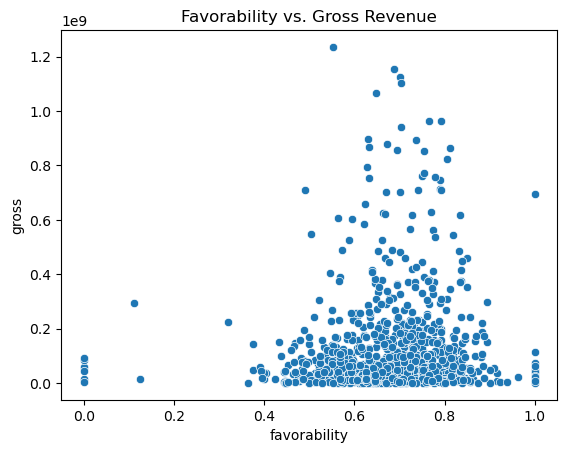

In [26]:
# Favorability vs. Gross
sns.scatterplot(x='favorability', y='gross', data=df_clean)
plt.title("Favorability vs. Gross Revenue")
plt.show()

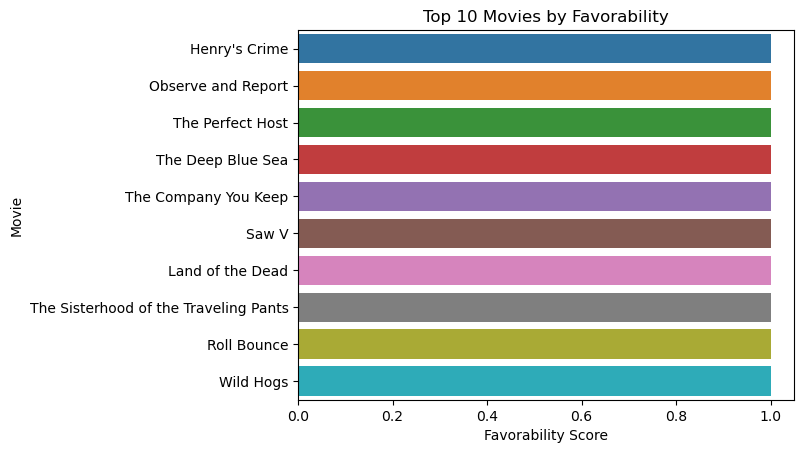

In [27]:
# Top 10 Movies by Favorability
top_fav = df[['name', 'favorability']].sort_values(by='favorability', ascending=False).head(10)
sns.barplot(y='name', x='favorability', data=top_fav)
plt.title("Top 10 Movies by Favorability")
plt.xlabel("Favorability Score")
plt.ylabel("Movie")
plt.show()